In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import shap

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
df = pd.read_csv("all_seasons.csv", index_col = 0)
df

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,1,3,...,33.1,10.2,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23
12840,John Butler Jr.,POR,20.0,213.36,86.182480,Florida State,USA,Undrafted,Undrafted,Undrafted,...,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23
12841,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,19,...,13.1,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23
12842,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,58,...,3.4,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23


# Preliminary Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12844 entries, 0 to 12843
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12844 non-null  object 
 1   team_abbreviation  12844 non-null  object 
 2   age                12844 non-null  float64
 3   player_height      12844 non-null  float64
 4   player_weight      12844 non-null  float64
 5   college            10990 non-null  object 
 6   country            12844 non-null  object 
 7   draft_year         12844 non-null  object 
 8   draft_round        12844 non-null  object 
 9   draft_number       12844 non-null  object 
 10  gp                 12844 non-null  int64  
 11  pts                12844 non-null  float64
 12  reb                12844 non-null  float64
 13  ast                12844 non-null  float64
 14  net_rating         12844 non-null  float64
 15  oreb_pct           12844 non-null  float64
 16  dreb_pct           12844 no

## Summary Statistics and EDA Part 1

In [4]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

### Numerical Variables

In [5]:
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,12844.0,27.045313,4.339211,18.000000,24.0000,26.00000,30.00000,44.00000
player_height,12844.0,200.555097,9.111090,160.020000,193.0400,200.66000,208.28000,231.14000
player_weight,12844.0,100.263279,12.426628,60.327736,90.7184,99.79024,108.86208,163.29312
gp,12844.0,51.154158,25.084904,1.000000,31.0000,57.00000,73.00000,85.00000
pts,12844.0,8.212582,6.016573,0.000000,3.6000,6.70000,11.50000,36.10000
reb,12844.0,3.558486,2.477885,0.000000,1.8000,3.00000,4.70000,16.30000
ast,12844.0,1.824681,1.800840,0.000000,0.6000,1.20000,2.40000,11.70000
net_rating,12844.0,-2.226339,12.665124,-250.000000,-6.4000,-1.30000,3.20000,300.00000
oreb_pct,12844.0,0.054073,0.043335,0.000000,0.0210,0.04000,0.08300,1.00000
dreb_pct,12844.0,0.140646,0.062513,0.000000,0.0960,0.13050,0.17900,1.00000


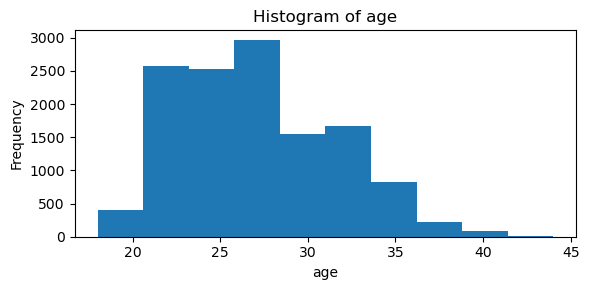

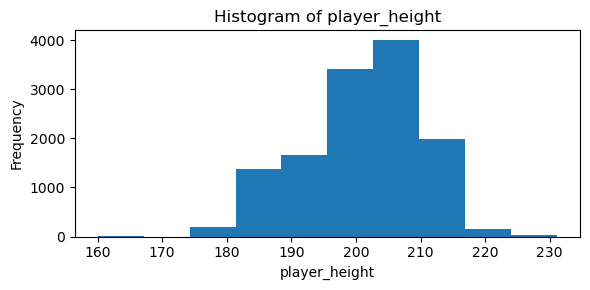

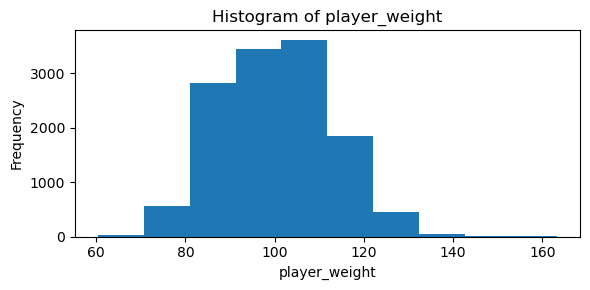

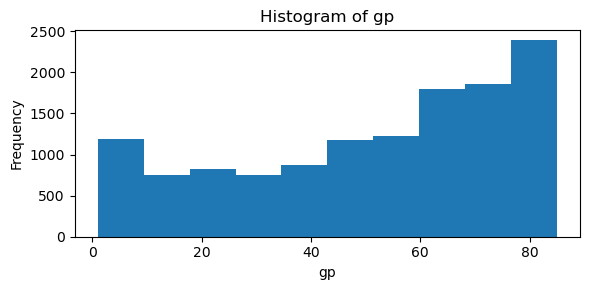

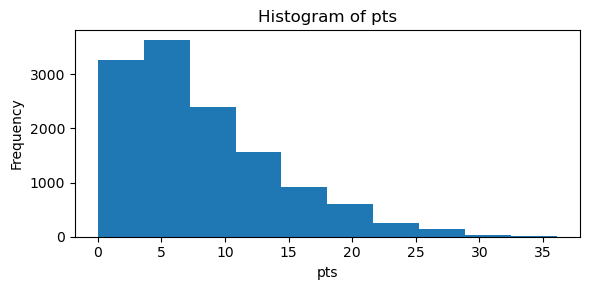

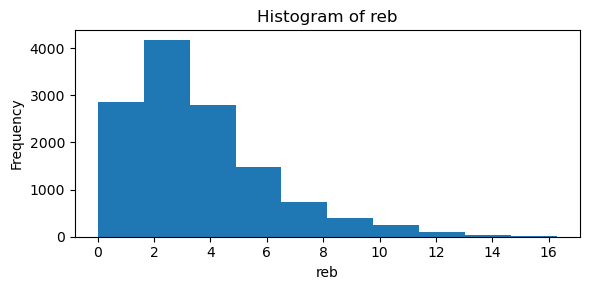

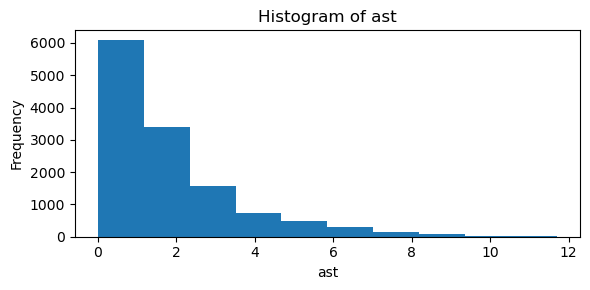

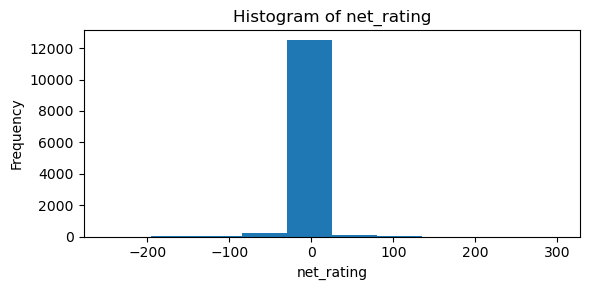

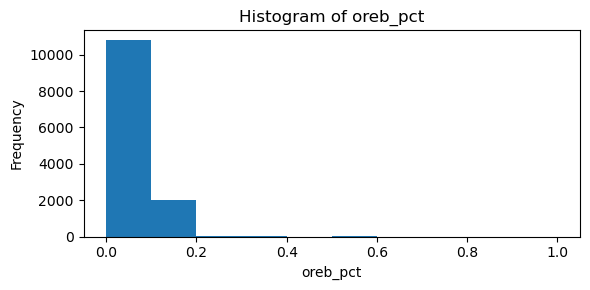

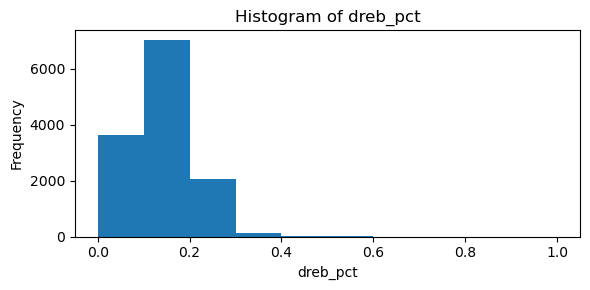

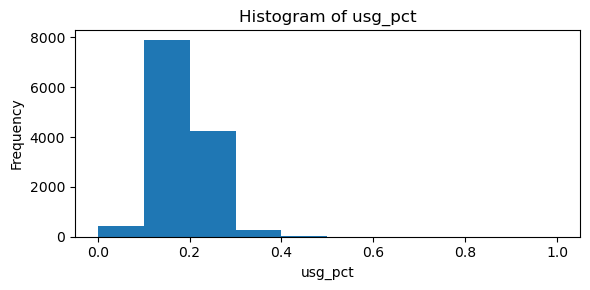

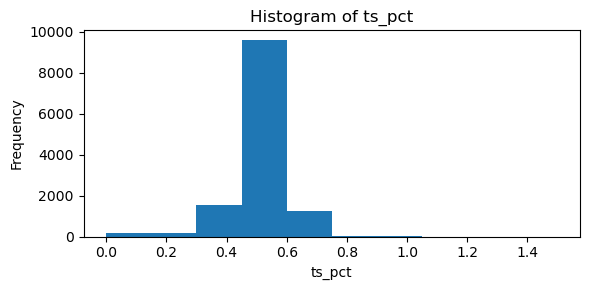

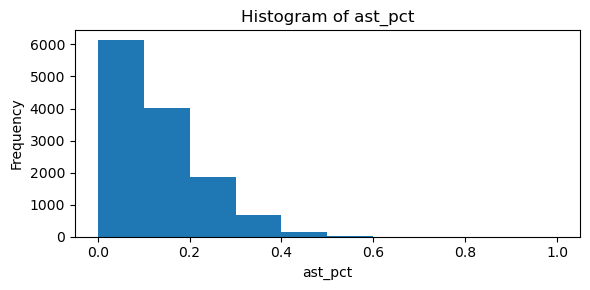

In [6]:
for col in df_num:
    fig = plt.figure(figsize=(6, 3))
    plt.hist(df_num[col])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

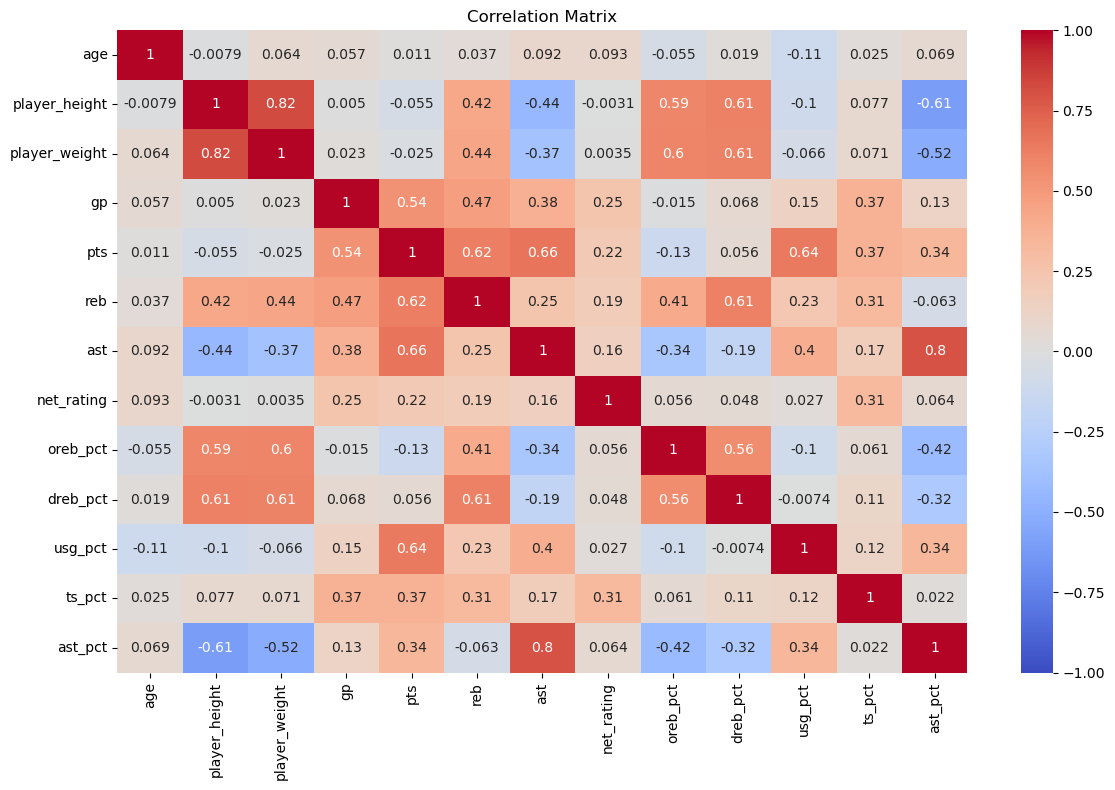

In [7]:
correlation_table = df_num.corr()
correlation_table

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_table, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Categorical Variables

In [8]:
for col in df_cat:
    print(df_cat[col].value_counts())
    print(df_cat[col].nunique())
    print()

player_name
Vince Carter       22
Dirk Nowitzki      21
Kevin Garnett      20
Udonis Haslem      20
Kobe Bryant        20
                   ..
Josh Akognon        1
Fab Melo            1
John Long           1
Luke Zeller         1
John Butler Jr.     1
Name: count, Length: 2551, dtype: int64
2551

team_abbreviation
CLE    450
TOR    446
MIA    443
DAL    443
WAS    442
LAC    442
ATL    439
PHI    438
SAS    434
HOU    433
LAL    429
ORL    428
IND    428
DEN    428
POR    428
MIL    427
GSW    426
NYK    426
BOS    425
CHI    423
DET    419
SAC    418
UTA    417
MIN    417
PHX    415
MEM    370
CHA    305
NJN    257
OKC    255
BKN    200
SEA    182
NOP    175
NOH    143
CHH     89
VAN     72
NOK     32
Name: count, dtype: int64
36

college
Kentucky                           447
Duke                               410
North Carolina                     355
UCLA                               318
Arizona                            293
                                  ... 
Portland      

## Feature Engineering and Data Preprocessing

In [9]:
df_filtered = df[df["gp"] >= 10].reset_index(drop = True)
df_filtered["player_bmi"] = df_filtered["player_weight"] / ((df_filtered["player_height"] / 100) ** 2)
df_filtered

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_bmi
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,25.439997
1,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,25.046833
2,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,24.717270
3,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,26.305303
4,Gerald Wilkins,ORL,33.0,198.12,102.058200,Tennessee-Chattanooga,USA,1985,2,47,...,2.2,2.2,-5.8,0.031,0.064,0.203,0.503,0.143,1996-97,26.001073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11650,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,1,3,...,10.2,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23,27.899564
11651,John Butler Jr.,POR,20.0,213.36,86.182480,Florida State,USA,Undrafted,Undrafted,Undrafted,...,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23,18.931847
11652,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,19,...,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23,24.217893
11653,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,58,...,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23,26.140281


In [10]:
cols = [
    "gp",
    "pts", 
    "reb", 
    "ast", 
    "net_rating", 
    "oreb_pct",
    "dreb_pct", 
    "usg_pct", 
    "ts_pct", 
    "ast_pct"
]

scaler = StandardScaler()
df_temp_scaled = pd.DataFrame(scaler.fit_transform(df_filtered[cols]), columns = cols)

weights = {
    "gp": 0.1,
    "pts": 0.2, 
    "reb": 0.1, 
    "ast": 0.1, 
    "net_rating": 0.15, 
    "oreb_pct": 0.05,
    "dreb_pct": 0.05, 
    "usg_pct": 0.1, 
    "ts_pct": 0.05, 
    "ast_pct": 0.1
}

df_filtered["raw_performance_score"] = sum(df_temp_scaled[col] * w for col, w in weights.items())

minmax = MinMaxScaler(feature_range=(0, 100))
df_filtered["performance_score"] = minmax.fit_transform(df_filtered[["raw_performance_score"]])

In [11]:
df_filtered["last_season_performance"] = df_filtered.groupby("player_name")["performance_score"].shift(1)
df_filtered["next_season_performance"] = df_filtered.groupby("player_name")["performance_score"].shift(-1)
df_filtered

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_bmi,raw_performance_score,performance_score,last_season_performance,next_season_performance
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,0.071,0.169,0.487,0.248,1996-97,25.439997,-0.167578,47.616400,NaN,28.977748
1,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,0.185,0.175,0.512,0.125,1996-97,25.046833,-0.056325,49.591658,NaN,54.259319
2,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,0.111,0.206,0.527,0.125,1996-97,24.717270,-0.020427,50.229019,NaN,50.744115
3,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,0.169,0.195,0.500,0.064,1996-97,26.305303,-0.648212,39.082897,NaN,36.547687
4,Gerald Wilkins,ORL,33.0,198.12,102.058200,Tennessee-Chattanooga,USA,1985,2,47,...,0.064,0.203,0.503,0.143,1996-97,26.001073,-0.034673,49.976078,NaN,41.627390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11650,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,1,3,...,0.243,0.370,0.655,0.233,2022-23,27.899564,2.143437,88.647723,88.520788,NaN
11651,John Butler Jr.,POR,20.0,213.36,86.182480,Florida State,USA,Undrafted,Undrafted,Undrafted,...,0.065,0.102,0.411,0.066,2022-23,18.931847,-1.337899,26.837728,NaN,NaN
11652,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,19,...,0.180,0.168,0.593,0.052,2022-23,24.217893,0.249045,55.013405,60.138867,NaN
11653,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,58,...,0.175,0.074,0.780,0.044,2022-23,26.140281,-0.370817,44.007968,45.405253,NaN


In [12]:
df_filtered_2 = df_filtered.dropna(subset = ["last_season_performance", "next_season_performance"]).reset_index(drop = True)
df_filtered_2

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_bmi,raw_performance_score,performance_score,last_season_performance,next_season_performance
0,Nick Van Exel,LAL,26.0,185.42,86.182480,Cincinnati,USA,1993,2,37,...,0.088,0.198,0.538,0.335,1997-98,25.067200,0.813684,65.038389,67.384496,60.460971
1,Nick Anderson,ORL,30.0,198.12,103.418976,Illinois,USA,1989,1,11,...,0.137,0.249,0.529,0.135,1997-98,26.347754,0.470177,58.939528,55.495621,56.921574
2,Muggsy Bogues,GSW,33.0,160.02,63.956472,Wake Forest,USA,1987,1,12,...,0.074,0.129,0.492,0.344,1997-98,24.976752,-0.106622,48.698653,59.443227,48.015467
3,Mookie Blaylock,ATL,31.0,185.42,83.914520,Oklahoma,USA,1989,1,12,...,0.110,0.202,0.462,0.288,1997-98,24.407537,0.838325,65.475878,70.727807,62.660171
4,Monty Williams,SAS,26.0,203.20,102.058200,Notre Dame,USA,1994,1,24,...,0.091,0.188,0.505,0.115,1997-98,24.717270,-0.116170,48.529131,50.329339,50.501635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7685,Torrey Craig,PHX,31.0,200.66,100.243832,South Carolina Upstate,USA,Undrafted,Undrafted,Undrafted,...,0.137,0.139,0.556,0.082,2021-22,24.896371,-0.210896,46.847308,45.707413,49.565953
7686,Tim Hardaway Jr.,DAL,30.0,195.58,92.986360,Michigan,USA,2013,1,24,...,0.114,0.214,0.520,0.115,2021-22,24.309183,0.138630,53.053020,57.401497,55.205221
7687,Tobias Harris,PHI,29.0,200.66,102.511792,Tennessee,USA,2011,1,19,...,0.164,0.214,0.566,0.158,2021-22,25.459637,0.778768,64.418465,68.033611,60.220219
7688,Tony Bradley,CHI,24.0,208.28,112.490816,North Carolina,USA,2017,1,28,...,0.196,0.128,0.600,0.065,2021-22,25.931159,-0.149741,47.933095,51.348007,44.608168


In [13]:
df_filtered_2.sort_values(["performance_score"], ascending = False).head(10)

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_bmi,raw_performance_score,performance_score,last_season_performance,next_season_performance
5941,Russell Westbrook,OKC,28.0,190.50,90.718400,UCLA,USA,2008,1,4,...,0.279,0.408,0.554,0.543,2016-17,24.998009,2.782834,100.000000,89.467440,91.049734
6738,Giannis Antetokounmpo,MIL,25.0,210.82,109.769264,NaN,Greece,2013,1,15,...,0.307,0.363,0.613,0.328,2019-20,24.697735,2.494068,94.873066,90.363876,86.865259
6023,James Harden,HOU,27.0,195.58,99.790240,Arizona State,USA,2009,1,3,...,0.212,0.341,0.613,0.505,2016-17,26.087904,2.483221,94.680480,82.810157,89.586893
7536,Nikola Jokic,DEN,27.0,210.82,128.820128,NaN,Serbia,2014,2,41,...,0.313,0.309,0.661,0.388,2021-22,28.984119,2.480465,94.631546,89.749544,93.250520
6461,James Harden,HOU,29.0,195.58,99.790240,Arizona State,USA,2009,1,3,...,0.157,0.396,0.616,0.394,2018-19,26.087904,2.364718,92.576498,89.586893,88.404843
6242,Russell Westbrook,OKC,29.0,190.50,90.718400,UCLA,USA,2008,1,4,...,0.226,0.326,0.524,0.464,2017-18,24.998009,2.278726,91.049734,100.000000,87.994488
6989,Luka Doncic,DAL,21.0,200.66,104.326160,NaN,Slovenia,2018,1,3,...,0.224,0.355,0.585,0.454,2019-20,25.910250,2.241406,90.387125,73.978304,87.068994
6406,Giannis Antetokounmpo,MIL,24.0,210.82,109.769264,NaN,Greece,2013,1,15,...,0.273,0.314,0.644,0.294,2018-19,24.697735,2.240096,90.363876,80.633290,94.873066
3791,LeBron James,CLE,25.0,203.20,113.398000,NaN,USA,2003,1,1,...,0.185,0.333,0.604,0.398,2009-10,27.463633,2.225899,90.111813,89.608595,85.123266
7349,Nikola Jokic,DEN,26.0,210.82,128.820128,NaN,Serbia,2014,2,41,...,0.237,0.293,0.647,0.377,2020-21,28.984119,2.205495,89.749544,80.316815,94.631546


In [14]:
cat_cols = df_filtered_2.select_dtypes(include=['object']).columns

for col in cat_cols:
    if col in ["player_name"]:
        continue
    freq = df_filtered_2[col].value_counts(normalize=True)
    rare_categories = freq[freq < 0.005].index
    df_filtered_2[col] = df_filtered_2[col].apply(lambda x: 'Other' if x in rare_categories else x)

In [15]:
df_filtered_2 = df_filtered_2.fillna("NULL")
df_filtered_2

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_bmi,raw_performance_score,performance_score,last_season_performance,next_season_performance
0,Nick Van Exel,LAL,26.0,185.42,86.182480,Cincinnati,USA,1993,2,37,...,0.088,0.198,0.538,0.335,1997-98,25.067200,0.813684,65.038389,67.384496,60.460971
1,Nick Anderson,ORL,30.0,198.12,103.418976,Illinois,USA,1989,1,11,...,0.137,0.249,0.529,0.135,1997-98,26.347754,0.470177,58.939528,55.495621,56.921574
2,Muggsy Bogues,GSW,33.0,160.02,63.956472,Wake Forest,USA,1987,1,12,...,0.074,0.129,0.492,0.344,1997-98,24.976752,-0.106622,48.698653,59.443227,48.015467
3,Mookie Blaylock,ATL,31.0,185.42,83.914520,Oklahoma,USA,1989,1,12,...,0.110,0.202,0.462,0.288,1997-98,24.407537,0.838325,65.475878,70.727807,62.660171
4,Monty Williams,SAS,26.0,203.20,102.058200,Notre Dame,USA,1994,1,24,...,0.091,0.188,0.505,0.115,1997-98,24.717270,-0.116170,48.529131,50.329339,50.501635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7685,Torrey Craig,PHX,31.0,200.66,100.243832,Other,USA,Undrafted,Undrafted,Undrafted,...,0.137,0.139,0.556,0.082,2021-22,24.896371,-0.210896,46.847308,45.707413,49.565953
7686,Tim Hardaway Jr.,DAL,30.0,195.58,92.986360,Michigan,USA,2013,1,24,...,0.114,0.214,0.520,0.115,2021-22,24.309183,0.138630,53.053020,57.401497,55.205221
7687,Tobias Harris,PHI,29.0,200.66,102.511792,Tennessee,USA,2011,1,19,...,0.164,0.214,0.566,0.158,2021-22,25.459637,0.778768,64.418465,68.033611,60.220219
7688,Tony Bradley,CHI,24.0,208.28,112.490816,North Carolina,USA,2017,1,28,...,0.196,0.128,0.600,0.065,2021-22,25.931159,-0.149741,47.933095,51.348007,44.608168


## Summary Statistics and EDA Part 2

In [16]:
df_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7690 entries, 0 to 7689
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              7690 non-null   object 
 1   team_abbreviation        7690 non-null   object 
 2   age                      7690 non-null   float64
 3   player_height            7690 non-null   float64
 4   player_weight            7690 non-null   float64
 5   college                  7690 non-null   object 
 6   country                  7690 non-null   object 
 7   draft_year               7690 non-null   object 
 8   draft_round              7690 non-null   object 
 9   draft_number             7690 non-null   object 
 10  gp                       7690 non-null   int64  
 11  pts                      7690 non-null   float64
 12  reb                      7690 non-null   float64
 13  ast                      7690 non-null   float64
 14  net_rating              

In [17]:
df_num_filtered_2 = df_filtered_2.select_dtypes(include=['int64', 'float64'])
df_cat_filtered_2 = df_filtered_2.select_dtypes(include=['object'])

### Numerical Variables

In [18]:
df_num_filtered_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,7690.0,27.595579,3.949451,19.000000,25.000000,27.000000,30.000000,42.000000
player_height,7690.0,200.752473,9.127874,160.020000,193.040000,200.660000,208.280000,228.600000
player_weight,7690.0,100.821906,12.377293,60.327736,91.171992,100.697424,109.315672,154.221280
gp,7690.0,61.750975,17.987887,10.000000,51.000000,66.000000,77.000000,85.000000
pts,7690.0,10.254343,5.998685,0.100000,5.700000,9.100000,13.700000,36.100000
reb,7690.0,4.312315,2.517289,0.200000,2.500000,3.700000,5.500000,16.000000
ast,7690.0,2.252991,1.926965,0.000000,0.900000,1.700000,3.000000,11.700000
net_rating,7690.0,-0.276268,6.181904,-43.700000,-4.200000,-0.100000,3.800000,28.600000
oreb_pct,7690.0,0.053993,0.038402,0.000000,0.022000,0.040000,0.083000,0.286000
dreb_pct,7690.0,0.145468,0.057006,0.020000,0.099000,0.135000,0.185000,0.390000


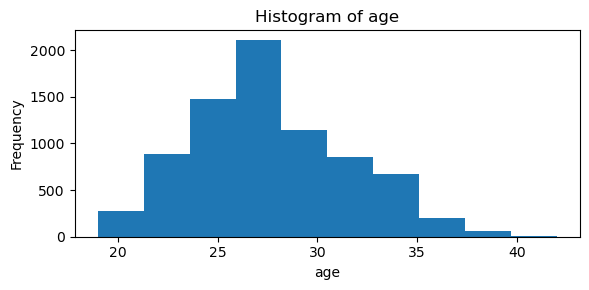

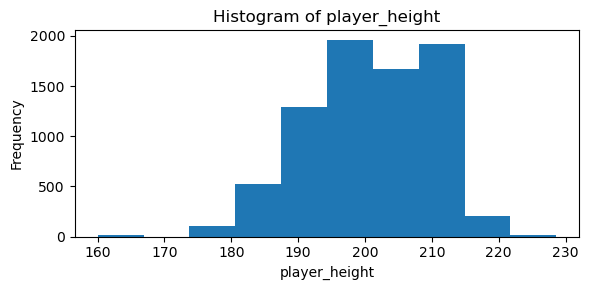

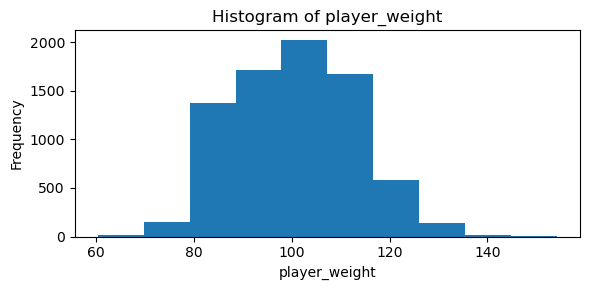

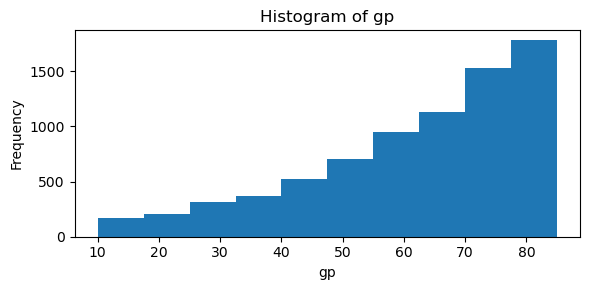

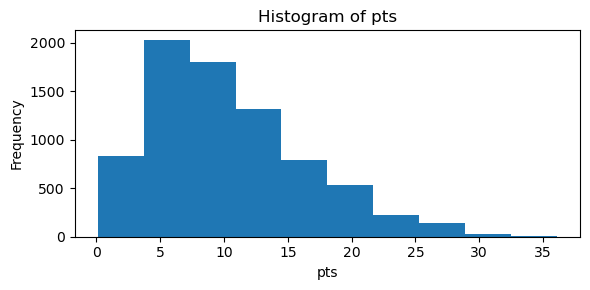

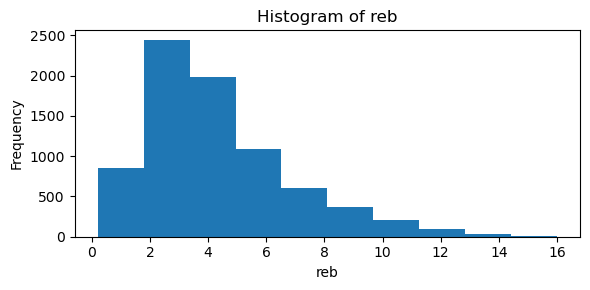

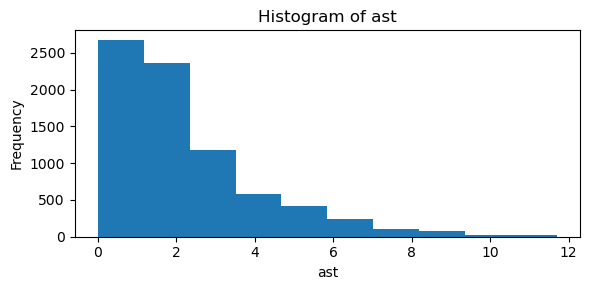

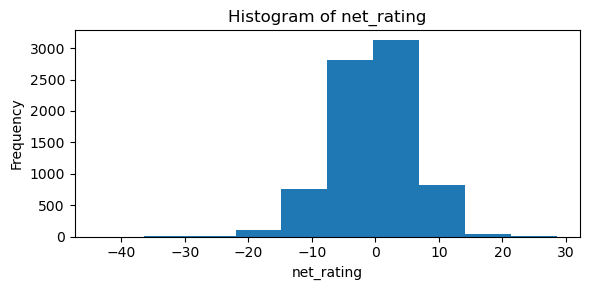

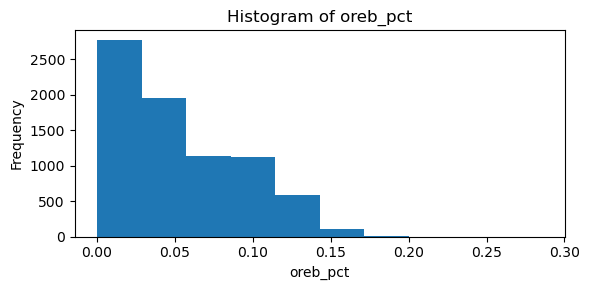

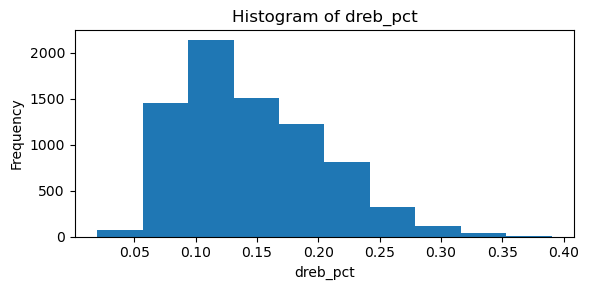

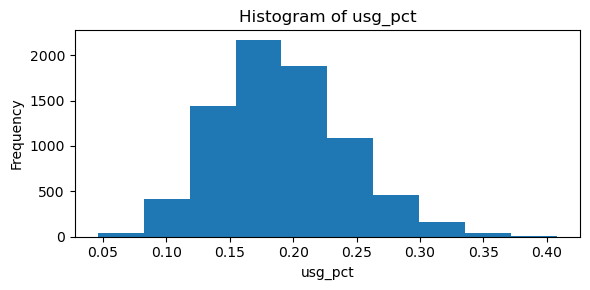

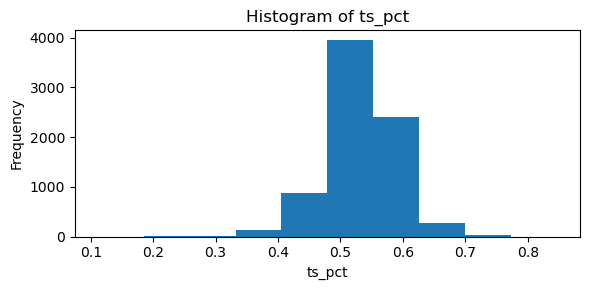

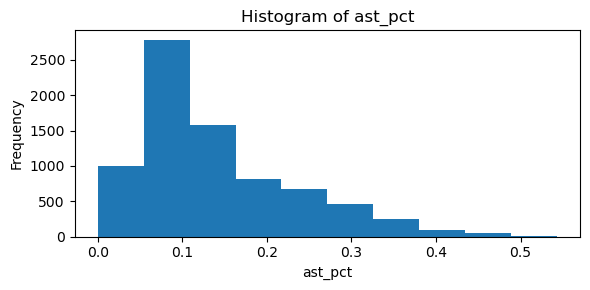

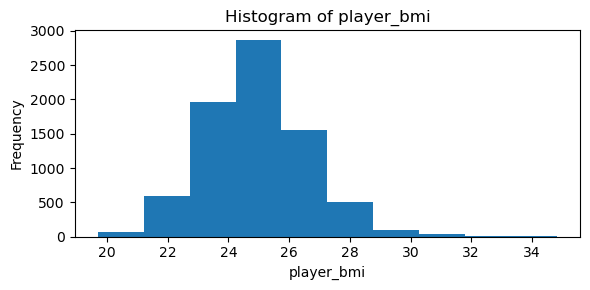

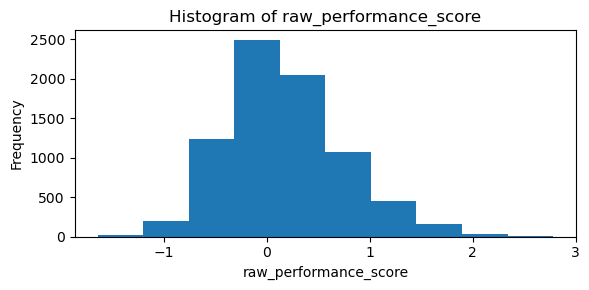

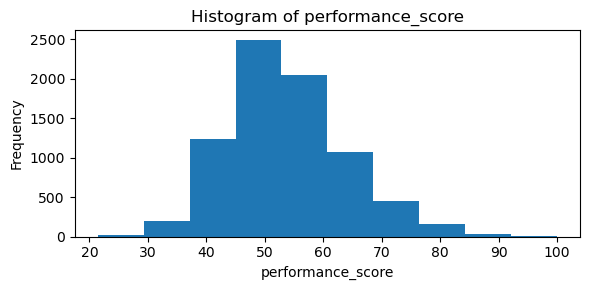

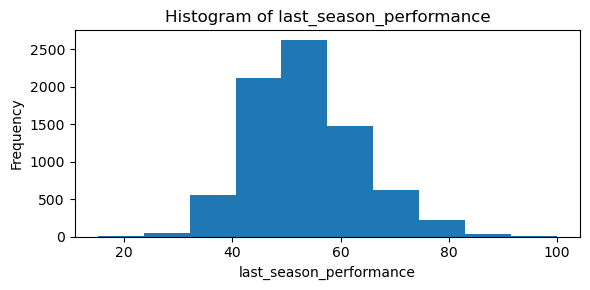

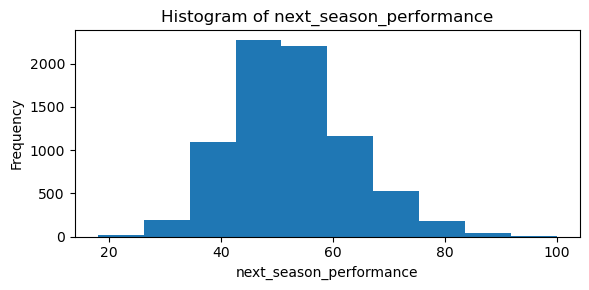

In [19]:
for col in df_num_filtered_2:
    fig = plt.figure(figsize=(6, 3))
    plt.hist(df_num_filtered_2[col])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

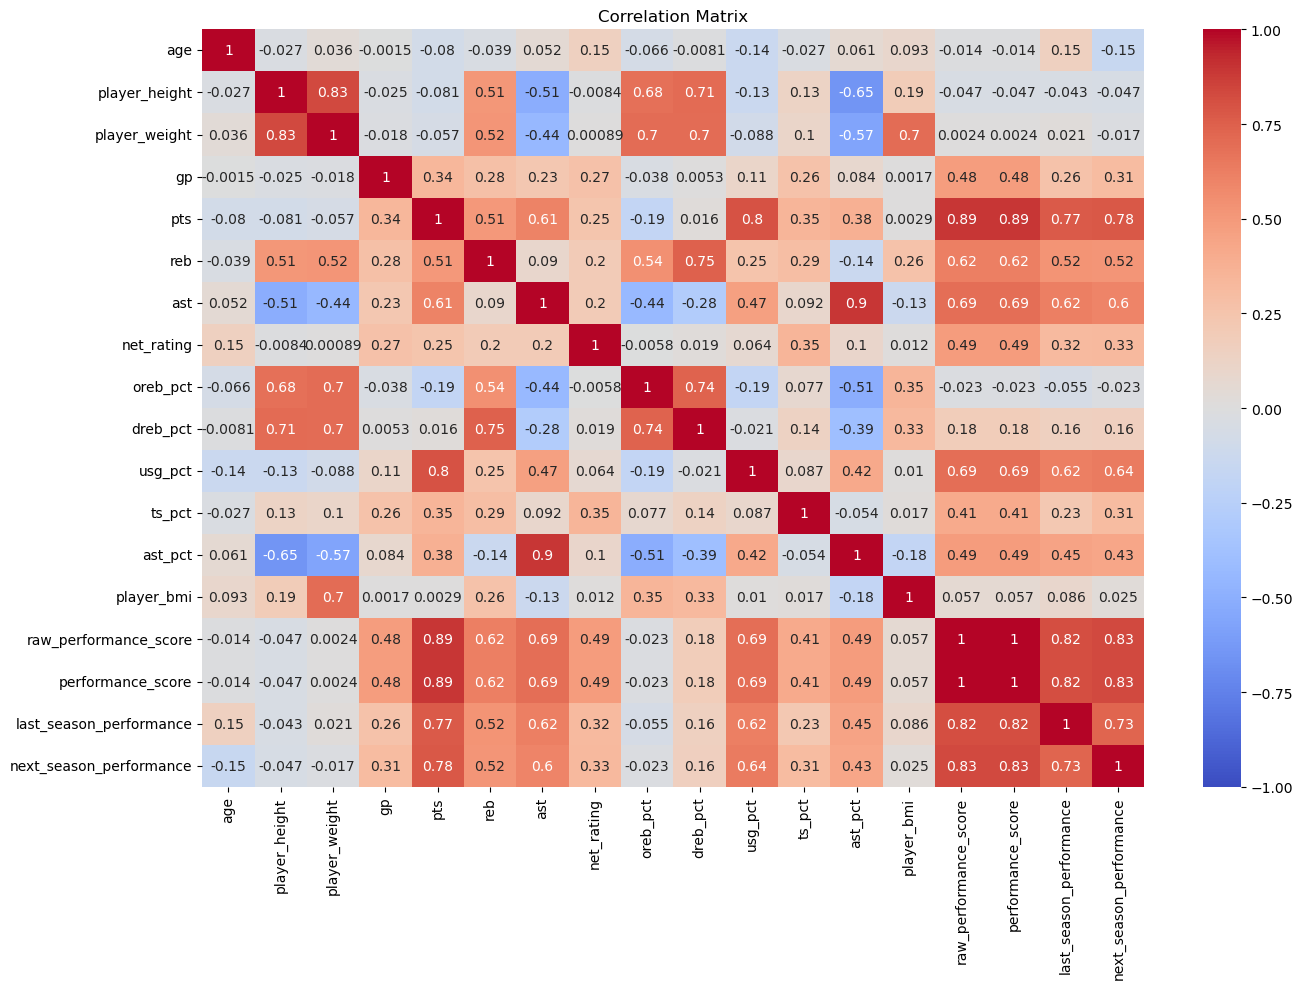

In [20]:
correlation_table_filtered_2 = df_num_filtered_2.corr()
correlation_table_filtered_2

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_table_filtered_2, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Categorical Variables

In [21]:
for col in df_cat_filtered_2:
    print(df_cat_filtered_2[col].value_counts())
    print(df_cat_filtered_2[col].nunique())
    print()

player_name
Vince Carter        20
Dirk Nowitzki       19
Kevin Garnett       18
LeBron James        18
Carmelo Anthony     17
                    ..
Tyrone Wallace       1
Mamadou N'diaye      1
Lonny Baxter         1
Johnathan Motley     1
Theo Maledon         1
Name: count, Length: 1414, dtype: int64
1414

team_abbreviation
DAL      284
IND      282
SAS      274
WAS      271
MIA      267
MIL      267
LAC      266
LAL      265
NYK      262
CLE      262
TOR      261
BOS      261
POR      260
DEN      259
UTA      259
MIN      258
CHI      258
SAC      255
HOU      250
DET      249
ORL      246
ATL      245
GSW      244
PHX      243
PHI      233
MEM      210
CHA      192
NJN      149
OKC      146
SEA      113
BKN      101
NOP      101
NOH       97
Other     54
CHH       46
Name: count, dtype: int64
35

college
Other             1511
NULL              1178
Kentucky           282
Duke               271
North Carolina     247
                  ... 
Creighton           36
Arizona State    

# Modeling Experiments

In [22]:
df_filtered_2

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_bmi,raw_performance_score,performance_score,last_season_performance,next_season_performance
0,Nick Van Exel,LAL,26.0,185.42,86.182480,Cincinnati,USA,1993,2,37,...,0.088,0.198,0.538,0.335,1997-98,25.067200,0.813684,65.038389,67.384496,60.460971
1,Nick Anderson,ORL,30.0,198.12,103.418976,Illinois,USA,1989,1,11,...,0.137,0.249,0.529,0.135,1997-98,26.347754,0.470177,58.939528,55.495621,56.921574
2,Muggsy Bogues,GSW,33.0,160.02,63.956472,Wake Forest,USA,1987,1,12,...,0.074,0.129,0.492,0.344,1997-98,24.976752,-0.106622,48.698653,59.443227,48.015467
3,Mookie Blaylock,ATL,31.0,185.42,83.914520,Oklahoma,USA,1989,1,12,...,0.110,0.202,0.462,0.288,1997-98,24.407537,0.838325,65.475878,70.727807,62.660171
4,Monty Williams,SAS,26.0,203.20,102.058200,Notre Dame,USA,1994,1,24,...,0.091,0.188,0.505,0.115,1997-98,24.717270,-0.116170,48.529131,50.329339,50.501635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7685,Torrey Craig,PHX,31.0,200.66,100.243832,Other,USA,Undrafted,Undrafted,Undrafted,...,0.137,0.139,0.556,0.082,2021-22,24.896371,-0.210896,46.847308,45.707413,49.565953
7686,Tim Hardaway Jr.,DAL,30.0,195.58,92.986360,Michigan,USA,2013,1,24,...,0.114,0.214,0.520,0.115,2021-22,24.309183,0.138630,53.053020,57.401497,55.205221
7687,Tobias Harris,PHI,29.0,200.66,102.511792,Tennessee,USA,2011,1,19,...,0.164,0.214,0.566,0.158,2021-22,25.459637,0.778768,64.418465,68.033611,60.220219
7688,Tony Bradley,CHI,24.0,208.28,112.490816,North Carolina,USA,2017,1,28,...,0.196,0.128,0.600,0.065,2021-22,25.931159,-0.149741,47.933095,51.348007,44.608168


In [23]:
df_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7690 entries, 0 to 7689
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              7690 non-null   object 
 1   team_abbreviation        7690 non-null   object 
 2   age                      7690 non-null   float64
 3   player_height            7690 non-null   float64
 4   player_weight            7690 non-null   float64
 5   college                  7690 non-null   object 
 6   country                  7690 non-null   object 
 7   draft_year               7690 non-null   object 
 8   draft_round              7690 non-null   object 
 9   draft_number             7690 non-null   object 
 10  gp                       7690 non-null   int64  
 11  pts                      7690 non-null   float64
 12  reb                      7690 non-null   float64
 13  ast                      7690 non-null   float64
 14  net_rating              

In [24]:
features = [
    'team_abbreviation', 
    'age', 
    'player_height', 
    'player_bmi', 
    'college', 
    'country', 
    'draft_round', 
    'draft_number', 
    'gp',
    'pts',
    'reb',
    'ast',
    'net_rating',
    'oreb_pct',
    'dreb_pct',
    'ts_pct',
    'last_season_performance'
]

categorical_features = [
    'team_abbreviation',
    'college',
    'country',
    'draft_round',
    'draft_number'
]

target = 'next_season_performance'

train = df_filtered_2[df_filtered_2['season'] != "2021-22"]
test = df_filtered_2[df_filtered_2['season'] == "2021-22"]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

numeric_features = [col for col in features if col not in categorical_features]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_features)
])

models_and_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state = 21),
        'params': {
            'max_depth': [3, 5, 10, 20, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state = 21),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 10, 20, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4],
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.1, 0.2, 0.5],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state = 21, verbosity = 0),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.5, 1, 5],
            'min_child_weight': [1, 5, 10],
            'reg_alpha': [0, 0.01, 0.1, 1],
            'reg_lambda': [0.1, 1, 10],
        }
    }
}

def get_n_iter(params, max_iter = 100):
    if not params:
        return 0
    total = len(list(ParameterGrid(params)))
    return min(max_iter, total)

results = []

for name, config in models_and_params.items():   
    print(f"Tuning and training: {name}")
    
    model = clone(config['model'])
    params = config['params']
    
    if params:
        n_iter = get_n_iter(params, max_iter = 100)
        search = RandomizedSearchCV(
            model,
            param_distributions = params,
            n_iter = n_iter,
            scoring = 'neg_root_mean_squared_error',
            cv = 5,
            random_state = 21,
            n_jobs = -1
        )
        pipeline = Pipeline(steps = [
            ('preprocessor', preprocessor),
            ('model', search)
        ])
    else:
        pipeline = Pipeline(steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    best_params = (
        pipeline.named_steps['model'].best_params_ if params else "NULL"
    )

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Best Params': best_params
    })

df_results = pd.DataFrame(results)
df_results

Tuning and training: Linear Regression
Tuning and training: Decision Tree
Tuning and training: Random Forest
Tuning and training: Support Vector Regression
Tuning and training: XGBoost


,Model,MAE,RMSE,R2,Best Params
0,Linear Regression,3.922855,5.035450,0.810790,NULL
1,Decision Tree,4.696315,5.901913,0.740071,"{'min_samples_split': 2, 'min_samples_leaf': 2..."
2,Random Forest,3.945122,4.999853,0.813455,"{'n_estimators': 300, 'min_samples_split': 10,..."
3,Support Vector Regression,3.756688,4.863878,0.823464,"{'kernel': 'rbf', 'gamma': 'auto', 'epsilon': ..."
4,XGBoost,3.743671,4.792402,0.828614,"{'subsample': 0.6, 'reg_lambda': 10, 'reg_alph..."


# Best and Final Model

In [25]:
df_results["Best Params"][4]

{'subsample': 0.6,
 'reg_lambda': 10,
 'reg_alpha': 0,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 1.0}

In [26]:
best_xgb_params = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 3,
    'subsample': 0.6,
    'colsample_bytree': 1,
    'gamma': 0.1,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'reg_lambda': 10
}

xgb_best_model = XGBRegressor(
    random_state = 21,
    verbosity = 0,
    **best_xgb_params
)

final_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_best_model)
])

final_xgb_pipeline.fit(X_train, y_train)
y_pred = final_xgb_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MAE: {mae}, RMSE: {rmse}, R2: {r2}")

XGBoost MAE: 3.7436713977308784, RMSE: 4.792401584075225, R2: 0.8286141726575611


In [27]:
df_final = df_filtered_2.copy()
df_final = df_final[df_final['season'] == "2021-22"].reset_index(drop = True)
df_final['pred_next_season_performance'] = y_pred

df_final["pred_next_season_performance_abs_error"] = (
    df_final["pred_next_season_performance"] - df_final["next_season_performance"]
).abs()

df_final["pred_next_season_performance_rel_error"] = (
    (df_final["pred_next_season_performance"] - df_final["next_season_performance"]) / 
    df_final["next_season_performance"]
).abs()

df_final

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast_pct,season,player_bmi,raw_performance_score,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
0,Vlatko Cancar,DEN,25.0,203.20,107.047712,NULL,Slovenia,2017,2,49,...,0.139,2021-22,25.925670,-0.444331,42.702738,32.598855,44.050884,42.245621,1.805264,0.040981
1,Tyus Jones,MEM,26.0,182.88,88.904032,Duke,USA,2015,1,24,...,0.285,2021-22,26.582084,0.391724,57.546625,51.081707,58.177254,54.722542,3.454712,0.059383
2,Tyrese Maxey,PHI,21.0,187.96,90.718400,Kentucky,USA,Other,1,21,...,0.191,2021-22,25.678196,0.627960,61.740913,50.255267,62.859847,64.240341,1.380494,0.021961
3,Tyrese Haliburton,IND,22.0,195.58,83.914520,Iowa State,USA,Other,1,12,...,0.335,2021-22,21.937555,0.766944,64.208534,55.376430,74.098916,62.664612,11.434304,0.154311
4,Tyler Herro,MIA,22.0,195.58,88.450440,Kentucky,USA,2019,1,13,...,0.205,2021-22,23.123369,0.990020,68.169182,57.799742,66.438279,66.780373,0.342093,0.005149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Torrey Craig,PHX,31.0,200.66,100.243832,Other,USA,Undrafted,Undrafted,Undrafted,...,0.082,2021-22,24.896371,-0.210896,46.847308,45.707413,49.565953,43.315376,6.250577,0.126106
316,Tim Hardaway Jr.,DAL,30.0,195.58,92.986360,Michigan,USA,2013,1,24,...,0.115,2021-22,24.309183,0.138630,53.053020,57.401497,55.205221,52.017826,3.187395,0.057737
317,Tobias Harris,PHI,29.0,200.66,102.511792,Tennessee,USA,2011,1,19,...,0.158,2021-22,25.459637,0.778768,64.418465,68.033611,60.220219,63.348457,3.128238,0.051947
318,Tony Bradley,CHI,24.0,208.28,112.490816,North Carolina,USA,2017,1,28,...,0.065,2021-22,25.931159,-0.149741,47.933095,51.348007,44.608168,48.908836,4.300668,0.096410


# Analyze Results


Top 15 Important Features - XGBoost Final Model:
                     feature  importance
4                        pts    0.316899
11   last_season_performance    0.127253
6                        ast    0.028426
5                        reb    0.025558
0                        age    0.024467
7                 net_rating    0.018476
9                   dreb_pct    0.010365
126              country_USA    0.009383
42     team_abbreviation_SAS    0.008346
3                         gp    0.007939
40     team_abbreviation_POR    0.007859
8                   oreb_pct    0.007640
136          draft_number_14    0.007416
79           college_Memphis    0.007281
110       college_Washington    0.007053


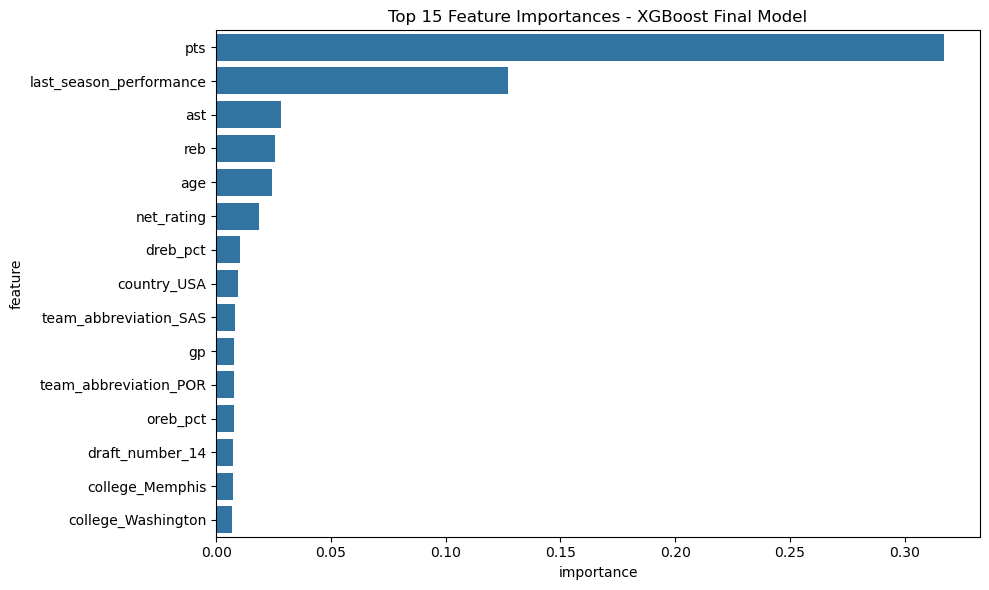

In [28]:
cat_encoder = final_xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances = final_xgb_pipeline.named_steps['model'].feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by = 'importance', ascending = False)

print("\nTop 15 Important Features - XGBoost Final Model:")
print(feat_imp_df.head(15))

plt.figure(figsize = (10, 6))
sns.barplot(data = feat_imp_df.head(15), x = 'importance', y = 'feature')
plt.title('Top 15 Feature Importances - XGBoost Final Model')
plt.tight_layout()
plt.show()

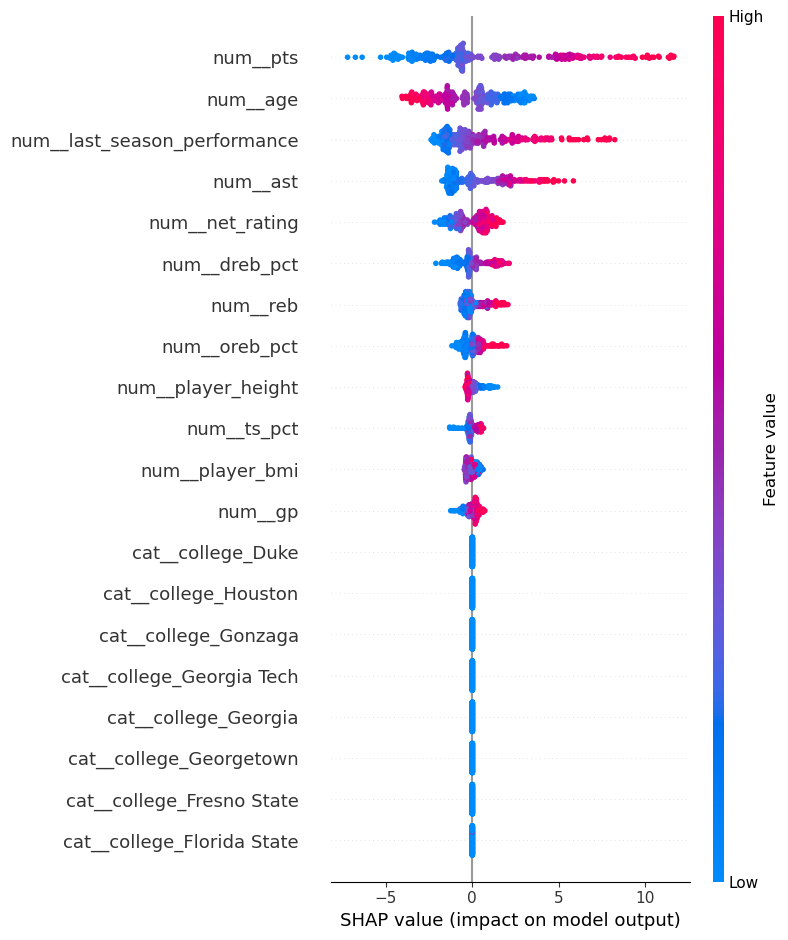

In [42]:
X_test_transformed = final_xgb_pipeline.named_steps['preprocessor'].transform(X_test)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

feature_names = final_xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.Explainer(final_xgb_pipeline.named_steps['model'], X_test_transformed)

shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, features = X_test_transformed, feature_names = feature_names)

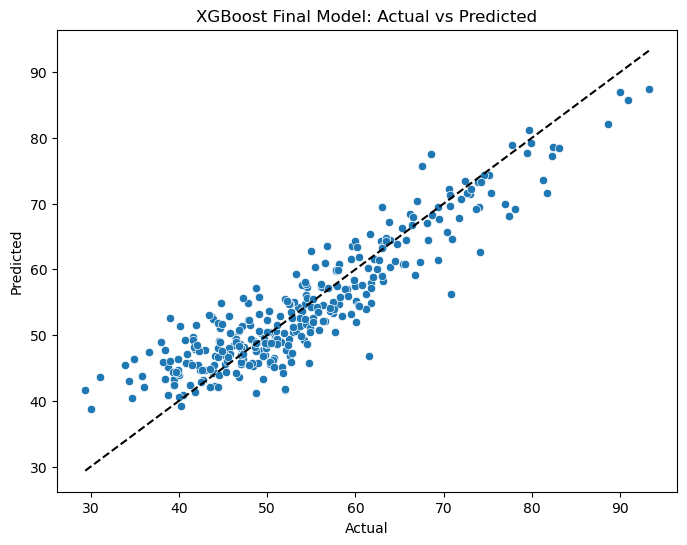

In [29]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test, y = y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Final Model: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [31]:
key_cols = [
    "player_name", 
    "performance_score", 
    "last_season_performance", 
    "next_season_performance", 
    "pred_next_season_performance",
    "pred_next_season_performance_abs_error",
    "pred_next_season_performance_rel_error"
]

df_final[key_cols].sort_values(["pred_next_season_performance"], ascending = False).head(10)

,player_name,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
166,Nikola Jokic,94.631546,89.749544,93.250520,87.459442,5.791077,0.062102
206,Luka Doncic,89.700500,87.068994,90.000907,86.960800,3.040107,0.033779
29,Giannis Antetokounmpo,89.582649,86.865259,90.851559,85.742607,5.108952,0.056234
265,Joel Embiid,88.520788,82.998979,88.647723,82.069893,6.577830,0.074202
307,Trae Young,83.687208,80.802503,79.706875,81.160248,1.453373,0.018234
58,James Harden,80.918791,83.226448,79.864941,79.268578,0.596363,0.007467
256,Kevin Durant,81.270701,78.274304,77.782125,78.862045,1.079920,0.013884
65,Jayson Tatum,80.395736,74.320301,82.438852,78.668419,3.770433,0.045736
85,Ja Morant,78.992682,69.738857,83.041084,78.380920,4.660164,0.056119
290,Stephen Curry,77.829318,81.200329,79.398260,77.668991,1.729269,0.021780


In [32]:
df_final[key_cols].sort_values(["pred_next_season_performance"], ascending = False).tail(10)

,player_name,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
147,Bol Bol,40.805511,30.072296,51.963108,41.699368,10.263741,0.197520
312,Thanasis Antetokounmpo,39.861139,45.054755,29.372026,41.673519,12.301493,0.418817
157,Anthony Gill,46.225129,40.740483,41.862953,41.289883,0.573070,0.013689
204,Luke Kornet,42.985230,42.758211,48.753292,41.173954,7.579338,0.155463
187,Rodney McGruder,42.568532,41.494232,40.482716,40.891579,0.408863,0.010100
124,Admiral Schofield,36.642589,34.368726,38.751588,40.816036,2.064448,0.053274
313,Theo Pinson,35.127849,21.414420,39.954033,40.602009,0.647976,0.016218
22,Garrett Temple,38.489540,46.172407,34.720920,40.408123,5.687203,0.163798
13,Wesley Matthews,41.893932,40.885760,40.207759,39.171696,1.036063,0.025768
294,Ryan Arcidiacono,31.961970,42.411138,30.026645,38.735527,8.708882,0.290038


In [34]:
df_final[key_cols].sort_values(["pred_next_season_performance_abs_error"], ascending = False).head(10)

,player_name,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
95,Brook Lopez,47.063128,54.686365,61.517688,46.797340,14.720348,0.239286
210,Lauri Markkanen,56.579920,52.585099,70.826995,56.275589,14.551406,0.205450
182,Richaun Holmes,51.834213,59.908882,38.995770,52.527790,13.532020,0.347012
176,Nerlens Noel,39.760433,48.189677,31.033323,43.673077,12.639754,0.407296
312,Thanasis Antetokounmpo,39.861139,45.054755,29.372026,41.673519,12.301493,0.418817
101,Bryn Forbes,47.752910,48.456088,33.914685,45.380089,11.465404,0.338066
3,Tyrese Haliburton,64.208534,55.376430,74.098916,62.664612,11.434304,0.154311
308,Trent Forrest,46.238092,40.006992,34.947178,46.359699,11.412522,0.326565
17,Evan Fournier,53.175262,56.473641,40.159424,51.443577,11.284153,0.280984
113,Chuma Okeke,47.429556,44.742860,37.906680,48.889004,10.982323,0.289720


In [35]:
df_final[key_cols].sort_values(["pred_next_season_performance_abs_error"], ascending = False).tail(10)

,player_name,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
47,Donovan Mitchell,74.838726,74.953192,74.534325,74.285957,0.248368,0.003332
127,Alec Burks,57.423211,56.350817,53.937131,53.703934,0.233197,0.004323
223,Malik Beasley,52.550484,55.009065,52.782201,52.554649,0.227552,0.004311
303,Kira Lewis Jr.,40.508274,46.401968,47.276467,47.071251,0.205216,0.004341
163,Obi Toppin,55.926407,45.445676,49.605790,49.485512,0.120279,0.002425
135,DeAndre Jordan,45.134617,54.627601,47.039839,46.963135,0.076704,0.001631
34,Georges Niang,49.920139,52.847074,48.896075,48.825809,0.070266,0.001437
8,Zach LaVine,68.883193,72.209189,69.386582,69.448395,0.061812,0.000891
119,Cory Joseph,49.113720,49.132626,48.591370,48.530575,0.060796,0.001251
263,John Konchar,49.606664,45.648735,48.755925,48.782196,0.026271,0.000539


In [36]:
df_final[key_cols].sort_values(["pred_next_season_performance_rel_error"], ascending = False).head(10)

,player_name,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
312,Thanasis Antetokounmpo,39.861139,45.054755,29.372026,41.673519,12.301493,0.418817
176,Nerlens Noel,39.760433,48.189677,31.033323,43.673077,12.639754,0.407296
182,Richaun Holmes,51.834213,59.908882,38.995770,52.527790,13.532020,0.347012
101,Bryn Forbes,47.752910,48.456088,33.914685,45.380089,11.465404,0.338066
308,Trent Forrest,46.238092,40.006992,34.947178,46.359699,11.412522,0.326565
152,Amir Coffey,49.225460,39.796341,36.657006,47.375504,10.718498,0.292400
294,Ryan Arcidiacono,31.961970,42.411138,30.026645,38.735527,8.708882,0.290038
113,Chuma Okeke,47.429556,44.742860,37.906680,48.889004,10.982323,0.289720
17,Evan Fournier,53.175262,56.473641,40.159424,51.443577,11.284153,0.280984
134,Davon Reed,43.832554,39.746275,34.296403,43.090519,8.794116,0.256415


In [37]:
df_final[key_cols].sort_values(["pred_next_season_performance_rel_error"], ascending = False).tail(10)

,player_name,performance_score,last_season_performance,next_season_performance,pred_next_season_performance,pred_next_season_performance_abs_error,pred_next_season_performance_rel_error
303,Kira Lewis Jr.,40.508274,46.401968,47.276467,47.071251,0.205216,0.004341
127,Alec Burks,57.423211,56.350817,53.937131,53.703934,0.233197,0.004323
223,Malik Beasley,52.550484,55.009065,52.782201,52.554649,0.227552,0.004311
47,Donovan Mitchell,74.838726,74.953192,74.534325,74.285957,0.248368,0.003332
163,Obi Toppin,55.926407,45.445676,49.605790,49.485512,0.120279,0.002425
135,DeAndre Jordan,45.134617,54.627601,47.039839,46.963135,0.076704,0.001631
34,Georges Niang,49.920139,52.847074,48.896075,48.825809,0.070266,0.001437
119,Cory Joseph,49.113720,49.132626,48.591370,48.530575,0.060796,0.001251
8,Zach LaVine,68.883193,72.209189,69.386582,69.448395,0.061812,0.000891
263,John Konchar,49.606664,45.648735,48.755925,48.782196,0.026271,0.000539
